In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

1. Load data and normalise them - as already implemented in the notebook.
2. Reproduce the closed-form solution (of the normal equations) from PW01 (based on pytorch tensors).
3. Implement (full batch) GD for linear regression - by using pytorch tensors. Don't use automatic differentiation, but implement the formulas for the gradient explicitly. Make sure that the your GD descent algorithm works correctly by checking that the solution gradually approaches the correct solution as computed in the first step (within numerical precision). Plot estimated MSE cost vs the number of epochs with matplotlib ("loss curve").
4. Play with different learning rates. Compare the trainings on the basis of the associated loss curves. Describe what you see and interpret what is going on. What is the maximal learning rate that you can use? What happens when choosing a larger learning rate?    
5. Solve the linear regression problem by using pytorch's autograd functionality.     

### 1. Load Data and Normalize

In [71]:
import pandas as pd

df = pd.read_csv("./data/lausanne-appart.csv")
N = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


In [72]:
x0 = df.values[:, 0]
x = (x0 - np.mean(x0)) / np.std(x0)
y0 = df.values[:, 2]
y = (y0 - np.mean(y0)) / np.std(y0)
print(y)

[-4.61804179e-01  4.60595257e-01 -1.37607675e+00 -1.34763271e+00
 -1.25823717e+00 -1.24198344e+00 -1.24198344e+00 -1.23792001e+00
 -1.22166627e+00 -1.20947597e+00 -1.20947597e+00 -1.20134910e+00
 -1.20134910e+00 -1.20134910e+00 -1.18509537e+00 -1.17696850e+00
 -1.16071477e+00 -1.15665133e+00 -1.15258790e+00 -1.14446103e+00
 -1.13633416e+00 -1.13633416e+00 -1.13633416e+00 -1.12008043e+00
 -1.10789013e+00 -1.08757296e+00 -1.07131923e+00 -1.03881176e+00
 -1.01443115e+00 -9.90050553e-01 -9.57543084e-01 -9.49416217e-01
 -9.29099048e-01 -9.16908747e-01 -8.68147544e-01 -8.64084110e-01
 -8.60020676e-01 -8.35640075e-01 -8.19386340e-01 -8.07196039e-01
 -8.03132605e-01 -7.95005738e-01 -7.95005738e-01 -7.86878871e-01
 -7.86878871e-01 -7.82815437e-01 -7.78752004e-01 -7.58434835e-01
 -7.54371402e-01 -7.54371402e-01 -7.38117667e-01 -7.29990800e-01
 -7.21863933e-01 -6.89356463e-01 -6.89356463e-01 -6.48722127e-01
 -6.40595260e-01 -6.40595260e-01 -6.36531826e-01 -6.08087791e-01
 -5.99960923e-01 -5.91834

Text(0, 0.5, 'rent_price')

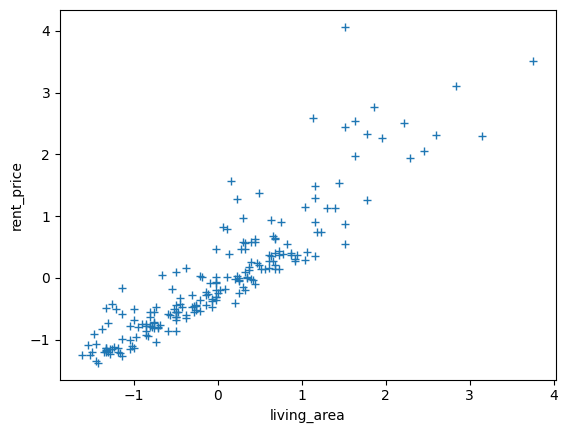

In [73]:
plt.plot(x, y, "+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### 2. Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

#### Solution of Normal Equations in Pytorch

Text(0, 0.5, 'rent_price')

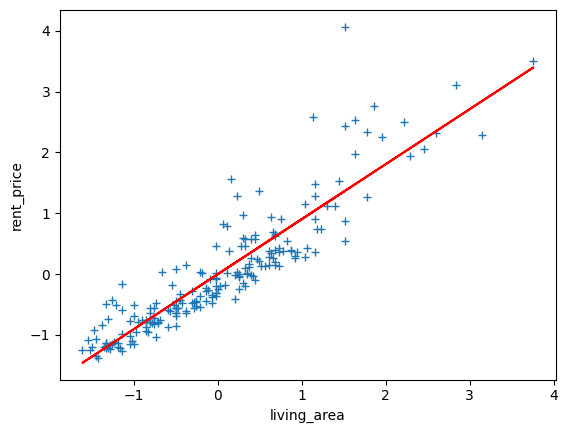

In [74]:
from numpy.linalg import inv

N = x.size

X_feature = torch.from_numpy(x.reshape(-1, 1))
X_ones = torch.ones(N, 1, dtype=torch.float32)
X = torch.cat((X_ones, X_feature), dim=1)

Y = torch.from_numpy(y.reshape(-1,1))

# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
a_exact = (torch.inverse(torch.matmul(torch.transpose(X, 0, 1), X))).matmul(X.T).mv(torch.from_numpy(y))


# prediction
def prediction(X, a):
    return torch.matmul(X, a)


Yhat = prediction(X, a_exact)
# plot
plt.plot(X[:, 1], Y, "+")
plt.plot(X[:, 1], Yhat, 'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost

In [75]:
def cost(X, Y, a):
    return torch.mean(((Y - X @ a) ** 2)).squeeze().item()

In [76]:
min_cost = cost(X, Y, a_exact)
print(min_cost)

1.81766694120838


### 3. Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

In [77]:
def gradient_cost(X, Y, a):
    return X.T @ (X @ a - Y) / N


In [78]:
def learn(lr, n_epochs):
    ## initial parameter
    a = torch.tensor([1.0, 1.0], dtype=torch.float64).reshape(2, 1)

    costs = []

    for epoch in range(n_epochs):
        costs.append(cost(X, Y, a))
        a = a - lr * gradient_cost(X, Y, a)

    costs.append(cost(X, Y, a))

    cost_gd = costs[-1]
    plt.plot(range(n_epochs + 1), costs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    print("Final cost: ", cost(X, Y, a))

Final cost:  0.19724945554664147


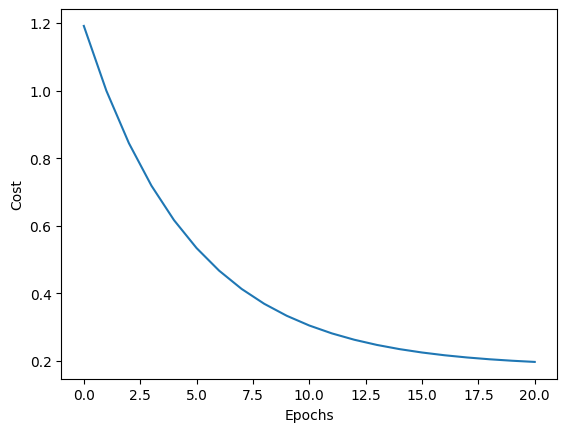

In [79]:
learn(lr=0.1, n_epochs=20)

Final cost:  0.5517212509066777


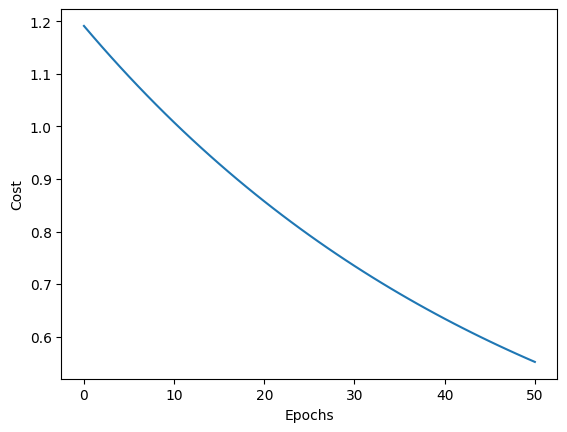

In [80]:
learn(lr=0.01, n_epochs=50)

Final cost:  0.19396797577070204


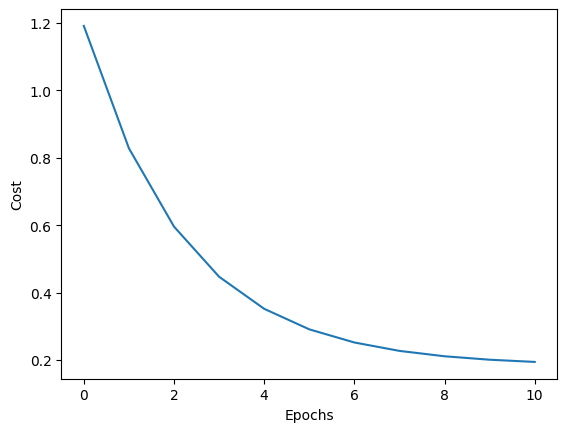

In [81]:
learn(lr=0.2, n_epochs=10)

### 4. Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

### 5. Use PyTorch's autograd

Epoch: 0: has loss: 6.782723
Epoch: 1: has loss: 5.953243
Epoch: 2: has loss: 5.268647
Epoch: 3: has loss: 4.701586
Epoch: 4: has loss: 4.230175
Epoch: 5: has loss: 3.836847
Epoch: 6: has loss: 3.507474
Epoch: 7: has loss: 3.230661
Epoch: 8: has loss: 2.997192
Epoch: 9: has loss: 2.799596
Epoch: 10: has loss: 2.631794
Epoch: 11: has loss: 2.488827
Epoch: 12: has loss: 2.366638
Epoch: 13: has loss: 2.261893
Epoch: 14: has loss: 2.171846
Epoch: 15: has loss: 2.094227
Epoch: 16: has loss: 2.027152
Epoch: 17: has loss: 1.969053
Epoch: 18: has loss: 1.918618
Epoch: 19: has loss: 1.874748
Final cost:  1.8747478723526


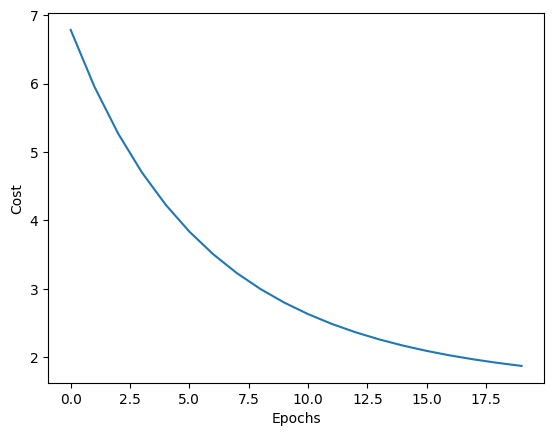

In [86]:
from torch import nn

linear = torch.nn.Linear(2, 1)


class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Forward pass
        out = self.linear(x)
        return out


model = LinearRegressionModel(1, 1)

epochs = 20
learning_rate=0.1
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_feature_float = X_feature.float()
Y_float = Y.float()

X_train = X_feature_float[:180,:]
Y_train = Y_float[:180,:]

X_test = X_feature_float[180:,:]
Y_test = Y_float[180:,:]

loss_list = []

for epoch in range(epochs):
    pred = model(X_train)
    loss = cost(pred, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        pred = model(X_test)
        mse_loss = cost(pred, Y_test).squeeze().item()
        loss_list.append(mse_loss)
    print("Epoch: %i: has loss: %f" %(epoch, mse_loss))
    
plt.plot(range(epochs), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Cost")
print("Final cost: ", mse_loss)